In [1]:
setwd("..")

In [2]:
source("Source/functions.R")
library("data.table")
library("circlize")

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [3]:
snv_info <- fread("Data/snv_loci_v2.csv")
snvIDs <- snv_info[, SNVID]
mito_barcodes <- read.csv("Data/mito_barcodes.csv", as.is = TRUE)
mitoIDs <- mito_barcodes[, "ID"] 

chrmbases_properties <- fread("Report/artifact/chrmbases_properties.csv.gz")
chrmbases <- chrmbases_properties[, ref]
nchrmbases <- length(chrmbases)

chrmgenes <- fread("Data/mm10.mito/chrM.gtf")
chrmgenes[, symbol := sapply(regmatches(V9, regexec('gene_name "(.*)"', V9, perl = TRUE)), '[', 2)]
chrmgenes <- chrmgenes[, list(symbol, V4, V5, V7)]

bases <- c("A", "G", "C", "T", "-")

MitoInfo <- fread("Report/metadata/MitoInfo.csv")
MitoInfo[, ExptID := factor(ExptID)]
MitoInfo[, MitoID := factor(MitoID, levels = mitoIDs)]
MitoInfo[, CellID := factor(CellID)]

CellInfo <- fread("Report/metadata/CellInfo.csv")

MouseInfo <- fread("Report/metadata/MouseInfo.csv")

Because we saw a lot of linkages heppening to the "suboptimal" reads, we went to filter these reads out and did the SNV AF call again.  
Here, we decided to work on the strictly filtered data for fears that suboptimal alignments could impact linkage analysis the most.

In [4]:
loose_support_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
strict_support_byposmut <- fread(file = "Report/SNVs/filter/basediffperc_cutdemux_strict_sub500k_q30_unstranded_highdepth_highaf_qcfltd_support_byposmut.csv")
support_byposmut <- strict_support_byposmut[pos %in% loose_support_byposmut[, unique(`pos`)]]
inherited_support_byposmut <- support_byposmut[nmice >= 3]
inherited_pos <- inherited_support_byposmut[, unique(pos)]
dim(inherited_support_byposmut)

[1] 141   9

Linkage per cell

In [5]:
inherited_allele_bymito_bypos <- fread("Report/SNVs/origin/strict_highdepth_inherited_allele_bymito_bypos.csv.gz")
inherited_allele_bymito_bypos <- inherited_allele_bymito_bypos[IsCtrl == "N", c(1:19, match(inherited_pos, names(inherited_allele_bymito_bypos))), with = FALSE]
dim(inherited_allele_bymito_bypos)

[1] 1610  155

In [6]:
mouseIDs <- MouseInfo[, sort(MouseID)]
cellUIDs <- sort(unique(inherited_allele_bymito_bypos[, CellUID]))
libraryMitoIDs <- unique(inherited_allele_bymito_bypos[, LibraryMitoID])

nmitosbycell <- inherited_allele_bymito_bypos[LibraryMitoID %in% libraryMitoIDs, uniqueN(LibraryMitoID), keyby = "CellUID"]

We want each cell to have >= 20 mitos.

In [7]:
cellUIDs <- nmitosbycell[V1 >= 20, CellUID]
cellUIDs

[1] "Mouse03_Neuron_2"     "Mouse03_Neuron_7"     "Mouse04_Neuron_11"   
 [4] "Mouse04_Neuron_2"     "Mouse05_Neuron_4"     "Mouse05_Neuron_6"    
 [7] "Mouse06_Neuron_2"     "Mouse06_Neuron_3"     "Mouse07_Astrocyte_1" 
[10] "Mouse07_Astrocyte_2"  "Mouse07_Astrocyte_4"  "Mouse07_Astrocyte_5" 
[13] "Mouse07_Astrocyte_6"  "Mouse07_Astrocyte_8"  "Mouse08_Astrocyte_21"
[16] "Mouse09_Astrocyte_1"  "Mouse09_Astrocyte_5"  "Mouse09_Neuron_1"    
[19] "Mouse09_Neuron_3"     "Mouse09_Neuron_5"     "Mouse12_Astrocyte_1" 
[22] "Mouse12_Astrocyte_2"  "Mouse12_Astrocyte_3"  "Mouse12_Neuron_2"    
[25] "Mouse12_Neuron_3"     "Mouse16&17_Neuron_4"

In [ ]:
inherited_allele_bymito_bypos_bycell <- sapply(cellUIDs, function(x) inherited_allele_bymito_bypos[CellUID == x], simplify = FALSE)
Tools$write_xlsx(inherited_allele_bymito_bypos_bycell, file = "Report/SNVs/linkage/inherited_allele_bymito_bypos_bycell.xlsx", row.names = FALSE)

We further filter out sites that have < 10 non-missing mitos.

In [9]:
inherited_allele_nafltd_bymito_bypos_bycell <- lapply(inherited_allele_bymito_bypos_bycell, function(Y) { 
    X <- as.matrix(Y[, !1:19])
    rownames(X) <- Y[, LibraryMitoID]
    nonna <- apply(X, 2, function(x) sum(x != ""))
    Y <- X[, nonna >= 10]
})
sapply(inherited_allele_nafltd_bymito_bypos_bycell, dim)

Mouse03_Neuron_2,Mouse03_Neuron_7,Mouse04_Neuron_11,Mouse04_Neuron_2,Mouse05_Neuron_4,Mouse05_Neuron_6,Mouse06_Neuron_2,Mouse06_Neuron_3,Mouse07_Astrocyte_1,Mouse07_Astrocyte_2,⋯,Mouse09_Astrocyte_5,Mouse09_Neuron_1,Mouse09_Neuron_3,Mouse09_Neuron_5,Mouse12_Astrocyte_1,Mouse12_Astrocyte_2,Mouse12_Astrocyte_3,Mouse12_Neuron_2,Mouse12_Neuron_3,Mouse16&17_Neuron_4
20,24,22,23,28,31,25,25,53,20,⋯,49,32,50,47,36,34,26,35,31,31
107,105,73,104,120,120,91,104,120,120,⋯,126,117,123,105,128,122,101,130,91,100


We filter for sites that have at least one minor allele with >= 5% frequency out of all mitos.  
This is because we do not want such case as T T T ... A T where the major allele T is 99% and the minor allele A is 1%. In this case, we do not have enough variation.

In [ ]:
bases <- c("A", "G", "C", "T", "-")
inherited_allele_nafltd_margin_bycell <- lapply(inherited_allele_nafltd_bymito_bypos_bycell, function(X) {
    apply(X, 2, function(x) sapply(bases, function(b) mean(grepl(x[x != "" & !is.na(x)], pattern = b))))
})
inherited_allele_nafltd_rarefltd_bycell <- mapply(function(X, Y) { y <- apply(Y, 2, function(k) { sum(k >= 0.05) >= 2 }); X[, y, drop = FALSE] }, X = inherited_allele_nafltd_bymito_bypos_bycell, Y = inherited_allele_nafltd_margin_bycell)
Tools$write_xlsx(inherited_allele_nafltd_rarefltd_bycell[sort(cellUIDs)], file = "Report/SNVs/linkage/inherited_allele_nafltd_rarefltd_bycell.xlsx", row.names = TRUE)
sapply(inherited_allele_nafltd_rarefltd_bycell, dim)

Mouse03_Neuron_2,Mouse03_Neuron_7,Mouse04_Neuron_11,Mouse04_Neuron_2,Mouse05_Neuron_4,Mouse05_Neuron_6,Mouse06_Neuron_2,Mouse06_Neuron_3,Mouse07_Astrocyte_1,Mouse07_Astrocyte_2,⋯,Mouse09_Astrocyte_5,Mouse09_Neuron_1,Mouse09_Neuron_3,Mouse09_Neuron_5,Mouse12_Astrocyte_1,Mouse12_Astrocyte_2,Mouse12_Astrocyte_3,Mouse12_Neuron_2,Mouse12_Neuron_3,Mouse16&17_Neuron_4
20,24,22,23,28,31,25,25,53,20,⋯,49,32,50,47,36,34,26,35,31,31
14,14,6,3,6,10,6,3,1,6,⋯,9,6,8,5,10,8,4,13,4,11


In [11]:
inherited_allele_nafltd_rarefltd_contab_bycell <- sapply(names(inherited_allele_nafltd_rarefltd_bycell), function(cellUID) { 
    X <- inherited_allele_nafltd_rarefltd_bycell[[cellUID]]
    suppressMessages(Genetics$link_bin_contab(X, lab = cellUID))
}, simplify = FALSE)

inherited_allele_nafltd_rarefltd_fet_bycell <- sapply(names(inherited_allele_nafltd_rarefltd_bycell), function(cellUID) {
    X <- inherited_allele_nafltd_rarefltd_contab_bycell[[cellUID]]
    suppressMessages(Genetics$link_bin_fet(X, lab = cellUID))
}, simplify = FALSE)

inherited_allele_nafltd_rarefltd_oddsratio_bycell <- do.call(rbind, lapply(names(inherited_allele_nafltd_rarefltd_contab_bycell), function(cellUID) { 
    X <- inherited_allele_nafltd_rarefltd_contab_bycell[[cellUID]]
    pos <- names(X)
    E <- do.call(rbind, lapply(pos, function(j) {
        do.call(rbind, lapply(pos, function(i) {
            Z <- sapply(bases, function(b) { 
                sapply(bases, function(a) {
                    Y <- X[[j]][[i]][[b]][[a]]
                    unname(inherited_allele_nafltd_rarefltd_fet_bycell[[cellUID]][[j]][[i]][[b]][[a]]["oddsratio"])
                }, simplify = TRUE)
            }, simplify = TRUE)
            K <- reshape2::melt(Z)
            colnames(K) <- c("allele1", "allele2", "oddsratio")
            data.table(pos1 = as.integer(i), pos2 = as.integer(j), K)
        }))
    }))
    data.table(CellUID = cellUID, E)
}))

inherited_allele_nafltd_rarefltd_pval_bycell <- do.call(rbind, lapply(names(inherited_allele_nafltd_rarefltd_contab_bycell), function(cellUID) { 
    X <- inherited_allele_nafltd_rarefltd_contab_bycell[[cellUID]]
    pos <- names(X)
    E <- do.call(rbind, lapply(pos, function(j) {
        do.call(rbind, lapply(pos, function(i) {
            Z <- sapply(bases, function(b) { 
                sapply(bases, function(a) {
                    Y <- X[[j]][[i]][[b]][[a]]
                    unname(inherited_allele_nafltd_rarefltd_fet_bycell[[cellUID]][[j]][[i]][[b]][[a]]["pval"])
                }, simplify = TRUE)
            }, simplify = TRUE)
            K <- reshape2::melt(Z)
            colnames(K) <- c("allele1", "allele2", "pval")
            data.table(pos1 = as.integer(i), pos2 = as.integer(j), K)
        }))
    }))
    data.table(CellUID = cellUID, E)
}))

Note, we did a lot of unnecessary comparisons for the sake of simple computation because not all allele pairs exist in our data. For example, we often have such contingency tables:
  
|              | allele 2 == A | allele 2 != A |
| ------------ | ------------- | ------------- |
| allele1 == T |             0 |             0 |
| allele1 != T |             0 |             5 |

or

|              | allele 2 == A | allele 2 != A |
| ------------ | ------------- | ------------- |
| allele1 == T |             0 |             3 |
| allele1 != T |             0 |             5 |

or

|              | allele 2 == A | allele 2 != A |
| ------------ | ------------- | ------------- |
| allele1 == T |             0 |             3 |
| allele1 != T |             4 |             5 |

So we prefilter them before multiple correction. 

In [12]:
inherited_allele_nafltd_rarefltd_oddsratio_bycell <- inherited_allele_nafltd_rarefltd_oddsratio_bycell[pos1 < pos2]
inherited_allele_nafltd_rarefltd_pval_bycell <- inherited_allele_nafltd_rarefltd_pval_bycell[pos1 < pos2]
inherited_allele_nafltd_rarefltd_fetstat_bycell <- merge.data.table(inherited_allele_nafltd_rarefltd_oddsratio_bycell, inherited_allele_nafltd_rarefltd_pval_bycell, by = c("CellUID", "pos1", "pos2", "allele1", "allele2"))

inherited_allele_nafltd_rarefltd_fetstat_bycell <- inherited_allele_nafltd_rarefltd_fetstat_bycell[oddsratio > 0]
inherited_allele_nafltd_rarefltd_fetstat_bycell[, padj := p.adjust(pval), by = "CellUID"]

inherited_allele_nafltd_rarefltd_fetstat_bycell[, `:=`(
    ref1 = chrmbases[as.integer(pos1)], 
    ref2 = chrmbases[as.integer(pos2)])
]
inherited_allele_nafltd_rarefltd_fetstat_bycell[, `:=`(
    mut1 = factor(paste0(ref1, ">", allele1), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "-"))), 
    mut2 = factor(paste0(ref2, ">", allele2), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "-"))))
]
inherited_allele_nafltd_rarefltd_fetstat_bycell[, `:=`(
    posmut1 = paste0(pos1, ":", mut1), 
    posmut2 = paste0(pos2, ":", mut2))
]
setcolorder(inherited_allele_nafltd_rarefltd_fetstat_bycell, names(inherited_allele_nafltd_rarefltd_fetstat_bycell)[c(1:3, 9:14, 4:8)])
dim(inherited_allele_nafltd_rarefltd_fetstat_bycell)

[1] 227  14

In [ ]:
head(inherited_allele_nafltd_rarefltd_fetstat_bycell)
fwrite(inherited_allele_nafltd_rarefltd_fetstat_bycell, file = "Report/SNVs/linkage/inherited_allele_nafltd_rarefltd_fetstat_bycell.csv")

CellUID,pos1,pos2,ref1,ref2,mut1,mut2,posmut1,posmut2,allele1,allele2,oddsratio,pval,padj
<chr>,<int>,<int>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
Mouse03_Neuron_2,2725,9457,C,T,C>T,T>C,2725:C>T,9457:T>C,T,C,Inf,0.08333333,0.4666667
Mouse03_Neuron_2,2725,12866,C,C,C>T,C>T,2725:C>T,12866:C>T,T,T,Inf,0.08333333,0.4666667
Mouse03_Neuron_2,3054,13728,A,T,A>G,T>C,3054:A>G,13728:T>C,G,C,Inf,0.08333333,0.4666667
Mouse03_Neuron_2,9027,9461,G,T,G>G,T>T,9027:G>G,9461:T>T,G,T,Inf,0.16666667,0.4666667
Mouse03_Neuron_2,9457,12866,T,C,T>C,C>T,9457:T>C,12866:C>T,C,T,Inf,0.13333333,0.4666667
Mouse03_Neuron_2,12809,13727,C,A,C>T,A>G,12809:C>T,13727:A>G,T,G,Inf,0.06666667,0.4666667


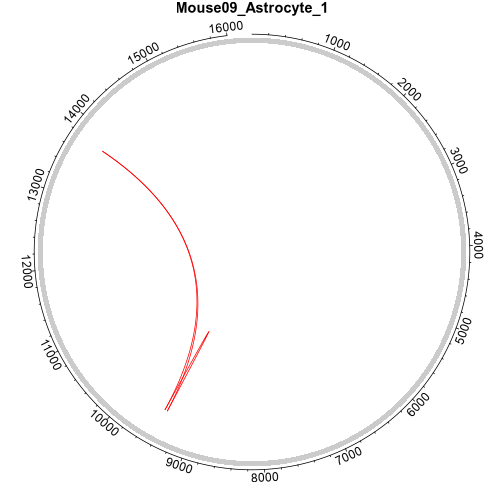

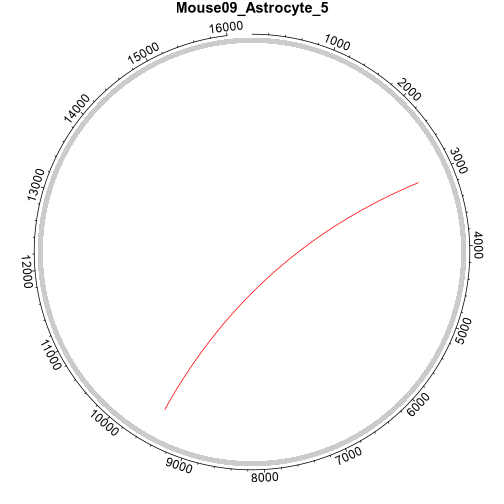

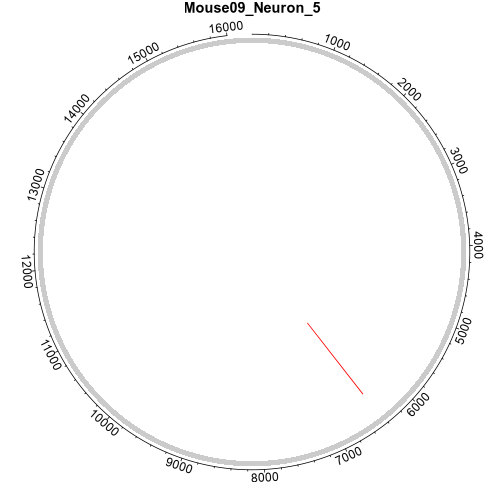

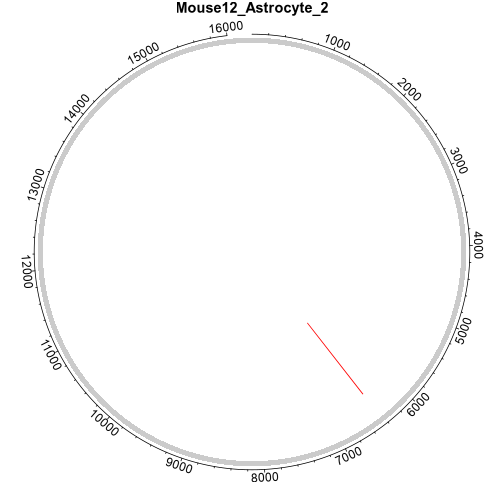

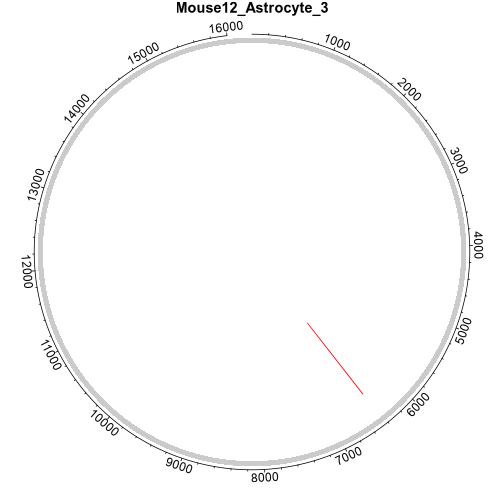

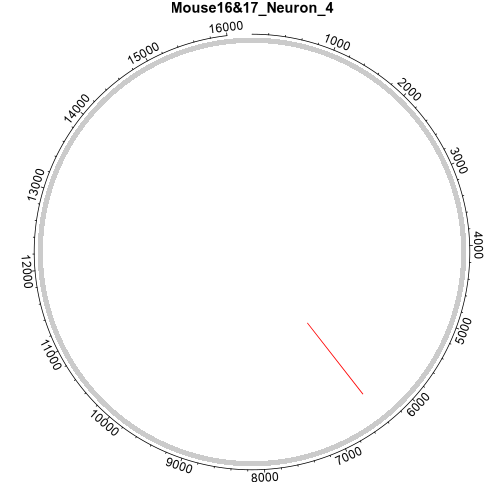

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 72)
for (cellUID in unique(inherited_allele_nafltd_rarefltd_fetstat_bycell[, CellUID])) {
    X <- inherited_allele_nafltd_rarefltd_fetstat_bycell[padj < 0.1 & CellUID == cellUID]
    if (nrow(X) > 0) {
        Y <- unique(X[, data.table(from = pos1, to = pos2, padj = padj)])
        circos.clear()
        circos.par(start.degree = 90)
        circos.initialize(sectors = rep("chrM", 16299), x = 1:16299, ring = TRUE)
        circos.track(sectors = rep("chrM", nrow(chrmgenes)), ylim = c(0, 1), panel.fun = function(x, y) { 
            circos.rect(xleft = 1, xright = 16299, ytop = 1, ybottom = 0.8, border = NA, col = adjustcolor("grey50", alpha.f = 0.4)) }, 
        bg.border = NA, track.height = 0.15)
        for (i in 1:nrow(Y)) {
            Y[i, circos.link(sector.index1 = "chrM", point1 = from, sector.index2 = "chrM", point2 = to, h.ratio = 0.5, lty = 1, col = adjustcolor("red", alpha = 1))]
        }
        circos.xaxis(major.at = seq(0, 16299, by = 1000))
        title(main = cellUID)
        circos.clear()
    }
}

 All mice together

We further filter out sites that have < 50 non-missing mitos.

In [15]:
inherited_allele_bymito_bypos_mat <- as.matrix(inherited_allele_bymito_bypos[, !1:19])
rownames(inherited_allele_bymito_bypos_mat) <- inherited_allele_bymito_bypos[, LibraryMitoID]

inherited_allele_nafltd_bymito_bypos <- inherited_allele_bymito_bypos_mat[, apply(inherited_allele_bymito_bypos_mat, 2, function(x) sum(x != "" & !is.na(x))) >= 50]
dim(inherited_allele_nafltd_bymito_bypos)

[1] 1610  136

We filter for sites that have at least one minor allele with >= 5% frequency out of all mitos.  
This is because we do not want such case as T T T ... A T where the major allele T is 99% and the minor allele A is 1%. In this case, we do not have enough variation. 

In [16]:
inherited_allele_nafltd_margin <- apply(inherited_allele_nafltd_bymito_bypos, 2, function(x) sapply(bases, function(b) mean(grepl(x[x != "" & !is.na(x)], pattern = b))))

inherited_allele_nafltd_rarefltd <- inherited_allele_nafltd_bymito_bypos[, apply(inherited_allele_nafltd_margin, 2, function(k) { sum(k >= 0.05) >= 2 }), drop = FALSE]
dim(inherited_allele_nafltd_rarefltd)

[1] 1610   17

In [17]:
inherited_allele_nafltd_rarefltd_dt <- data.table(LibraryMitoID = rownames(inherited_allele_nafltd_rarefltd), inherited_allele_nafltd_rarefltd)
inherited_allele_nafltd_rarefltd_dt <- MitoInfo[inherited_allele_nafltd_rarefltd_dt, on = "LibraryMitoID"]

In [18]:
inherited_allele_nafltd_rarefltd_contab <- local({
    X <- inherited_allele_nafltd_rarefltd
    suppressMessages(Genetics$link_bin_contab(X, lab = "all"))
})

inherited_allele_nafltd_rarefltd_fet <- local({
    X <- inherited_allele_nafltd_rarefltd_contab
    suppressMessages(Genetics$link_bin_fet(X, lab = "all"))
})

inherited_allele_nafltd_rarefltd_oddsratio <- local({ 
    X <- inherited_allele_nafltd_rarefltd_fet
    pos <- names(X)
    E <- do.call(rbind, lapply(pos, function(j) {
        do.call(rbind, lapply(pos, function(i) {
            Z <- sapply(bases, function(b) { 
                sapply(bases, function(a) {
                    unname(X[[j]][[i]][[b]][[a]][["oddsratio"]])
                }, simplify = TRUE)
            }, simplify = TRUE)
            K <- reshape2::melt(Z)
            colnames(K) <- c("allele1", "allele2", "oddsratio")
            data.table(pos1 = as.integer(i), pos2 = as.integer(j), K)
        }))
    }))
    data.table(E)
})

inherited_allele_nafltd_rarefltd_pval <- local({
    X <- inherited_allele_nafltd_rarefltd_fet
    pos <- names(X)
    E <- do.call(rbind, lapply(pos, function(j) {
        do.call(rbind, lapply(pos, function(i) {
            Z <- sapply(bases, function(b) { 
                sapply(bases, function(a) {
                    unname(X[[j]][[i]][[b]][[a]][["pval"]])
                }, simplify = TRUE)
            }, simplify = TRUE)
            K <- reshape2::melt(Z)
            colnames(K) <- c("allele1", "allele2", "pval")
            data.table(pos1 = as.integer(i), pos2 = as.integer(j), K)
        }))
    }))
    data.table(E)
})

In [19]:
inherited_allele_nafltd_rarefltd_oddsratio <- inherited_allele_nafltd_rarefltd_oddsratio[pos1 < pos2]
inherited_allele_nafltd_rarefltd_pval <- inherited_allele_nafltd_rarefltd_pval[pos1 < pos2]
inherited_allele_nafltd_rarefltd_fetstat <- merge.data.table(inherited_allele_nafltd_rarefltd_oddsratio, inherited_allele_nafltd_rarefltd_pval, by = c("pos1", "pos2", "allele1", "allele2"))

inherited_allele_nafltd_rarefltd_fetstat <- inherited_allele_nafltd_rarefltd_fetstat[oddsratio > 0]
inherited_allele_nafltd_rarefltd_fetstat[, padj := p.adjust(pval)]
inherited_allele_nafltd_rarefltd_fetstat[, `:=`(
    ref1 = chrmbases[as.integer(pos1)], 
    ref2 = chrmbases[as.integer(pos2)])
]
inherited_allele_nafltd_rarefltd_fetstat[, `:=`(
    mut1 = factor(paste0(ref1, ">", allele1), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "-"))), 
    mut2 = factor(paste0(ref2, ">", allele2), levels = paste0(rep(c("A", "C", "G", "T"), each = 5), ">", c("A", "C", "G", "T", "-"))))
]
inherited_allele_nafltd_rarefltd_fetstat[, `:=`(
    posmut1 = paste0(pos1, ":", mut1), 
    posmut2 = paste0(pos2, ":", mut2))
]
setcolorder(inherited_allele_nafltd_rarefltd_fetstat, names(inherited_allele_nafltd_rarefltd_fetstat)[c(1:2, 8:13, 3:7)])
dim(inherited_allele_nafltd_rarefltd_fetstat)

[1] 246  13

In [ ]:
head(inherited_allele_nafltd_rarefltd_fetstat)
fwrite(inherited_allele_nafltd_rarefltd_fetstat, file = "Report/SNVs/linkage/inherited_allele_nafltd_rarefltd_fetstat.csv")

pos1,pos2,ref1,ref2,mut1,mut2,posmut1,posmut2,allele1,allele2,oddsratio,pval,padj
<int>,<int>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
6430,6432,A,G,A>C,G>C,6430:A>C,6432:G>C,C,C,Inf,1.069793e-115,2.631691e-113
6430,6432,A,G,A>-,G>C,6430:A>-,6432:G>C,-,C,Inf,1.186441e-01,1.000000e+00
6430,9027,A,G,A>C,G>A,6430:A>C,9027:G>A,C,A,Inf,2.262399e-01,1.000000e+00
6430,9027,A,G,A>C,G>G,6430:A>C,9027:G>G,C,G,3.434186,1.665660e-06,4.047553e-04
6430,9461,A,T,A>C,T>A,6430:A>C,9461:T>A,C,A,Inf,1.524390e-01,1.000000e+00
6430,9461,A,T,A>C,T>C,6430:A>C,9461:T>C,C,C,Inf,5.153597e-01,1.000000e+00


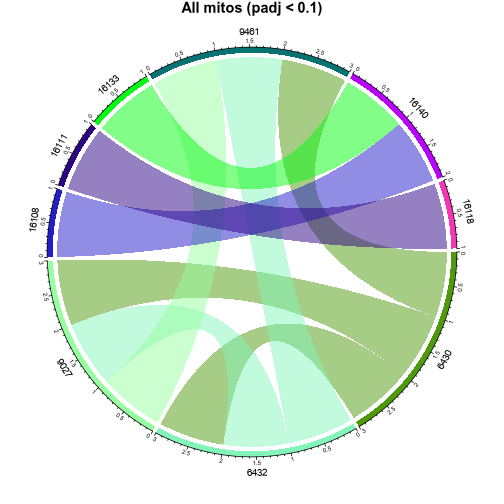

In [21]:
inherited_allele_nafltd_rarefltd_fetstat_sig <- inherited_allele_nafltd_rarefltd_fetstat[padj < 0.1]
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 72)
chordDiagram(unique(inherited_allele_nafltd_rarefltd_fetstat_sig[, list(pos1, pos2)]))
title(main = "All mitos (padj < 0.1)")
circos.clear()

In [22]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: openSUSE Tumbleweed

Matrix products: default
BLAS:   /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRblas.so 
LAPACK: /home/lenovo/Applications/R/4.4.0/lib64/R/lib/libRlapack.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: America/New_York
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] circlize_0.4.16   data.table_1.16.2

loaded via a namespace (and not attached):
 [1] crayon_1.5.3        vctrs_0.6.5         cli_3.6.3          
 [4] rlang_1.1.4         